In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using StreamMacros, Main.CoherentStructures
using Tensors, Arpack 
using Plots
using OrdinaryDiffEq

In [3]:
# Parameters
grid_resolution        = 100
quadrature_order       = 5
selected_ev            = 4        # which Eigenvector to choose
ϵ                      = 0.2      # perturbation
t₀                      = 0.6     # parameter value corresponding to ϵ=0
solver_tolerance       = 1e-5
solver                 = OrdinaryDiffEq.BS5();

In [4]:
rot_double_gyre = @velo_from_stream Ψ_rot_dgyre begin
    st          = heaviside(t)*heaviside(1-t)*t^2*(3-2*t) + heaviside(t-1)
    heaviside(x)= 0.5*(sign(x) + 1)
    Ψ_P         = sin(2π*x)*sin(π*y)
    Ψ_F         = sin(π*x)*sin(2π*y)
    Ψ_rot_dgyre = (1-st) * Ψ_P + st * Ψ_F
end
T(x,p) = flow(rot_double_gyre, x, [0.0, t₀ + p],
    tolerance = solver_tolerance, solver = solver)[end];

In [5]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx, _ = regularTriangularGrid((grid_resolution, grid_resolution), LL, UR, quadrature_order = quadrature_order);

In [6]:
M = assembleMassMatrix(ctx);

In [7]:
# assemble K
DT₀(x) = linearized_flow_autodiff(y -> T(y,0) , x)
A₀(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DT₀(x))))
@time K = assembleStiffnessMatrix(ctx, A₀);

 18.197497 seconds (64.98 M allocations: 3.712 GiB, 5.22% gc time)


In [8]:
# solve the linear system
@time λ₀, u₀ = eigs(K, M, which=:SM)
@assert all(imag.(u₀) .== 0)
@assert all(imag.(λ₀) .== 0)
u₀ = real.(u₀[:,selected_ev])
λ₀ = real.(λ₀[selected_ev])
u₀ = u₀ ./ sqrt(u₀'*M*u₀)        # L2 normalization
u₀ = u₀*sign(sum(u₀))            # fix sign
λ₀

  3.160761 seconds (9.41 M allocations: 530.941 MiB, 4.18% gc time)


-237.5743751050256

In [9]:
# assemble the linear response matrix L
Adot(x) = linear_response_tensor(T, x, 0)
@time L = assembleStiffnessMatrix(ctx, Adot);

 32.424939 seconds (55.91 M allocations: 4.310 GiB, 2.66% gc time)


In [10]:
# solve the system for the derivative u_dot
lhs = [K-λ₀*M   -M*u₀
        u₀'*M      0]
rhs = [-L*u₀    ;  0]

@time b = lhs \ rhs
u_dot = b[1:end-1]
λ_dot = b[end]

  0.694542 seconds (2.41 M allocations: 135.941 MiB, 4.27% gc time)


-313.09328137043366

In [11]:
# calculate the exact uϵ
DTϵ(x) = linearized_flow_autodiff(y -> T(y,ϵ) , x)
Aϵ(x) = 0.5*(one(Tensor{2,2}) + dott(inv(DTϵ(x))))
Kϵ = assembleStiffnessMatrix(ctx, Aϵ)
λϵ, uϵ = eigs(Kϵ, M, which=:SM)
@assert all(imag.(uϵ) .== 0)
@assert all(imag.(λϵ) .== 0)
uϵ = real.(uϵ[:,selected_ev])
λϵ = real.(λϵ[selected_ev])
uϵ = uϵ ./ sqrt(uϵ'*M*uϵ)
uϵ = uϵ*sign(sum(uϵ))
λϵ

-318.8020448956184

In [12]:
λ₀ + ϵ*λ_dot

-300.1930313791123

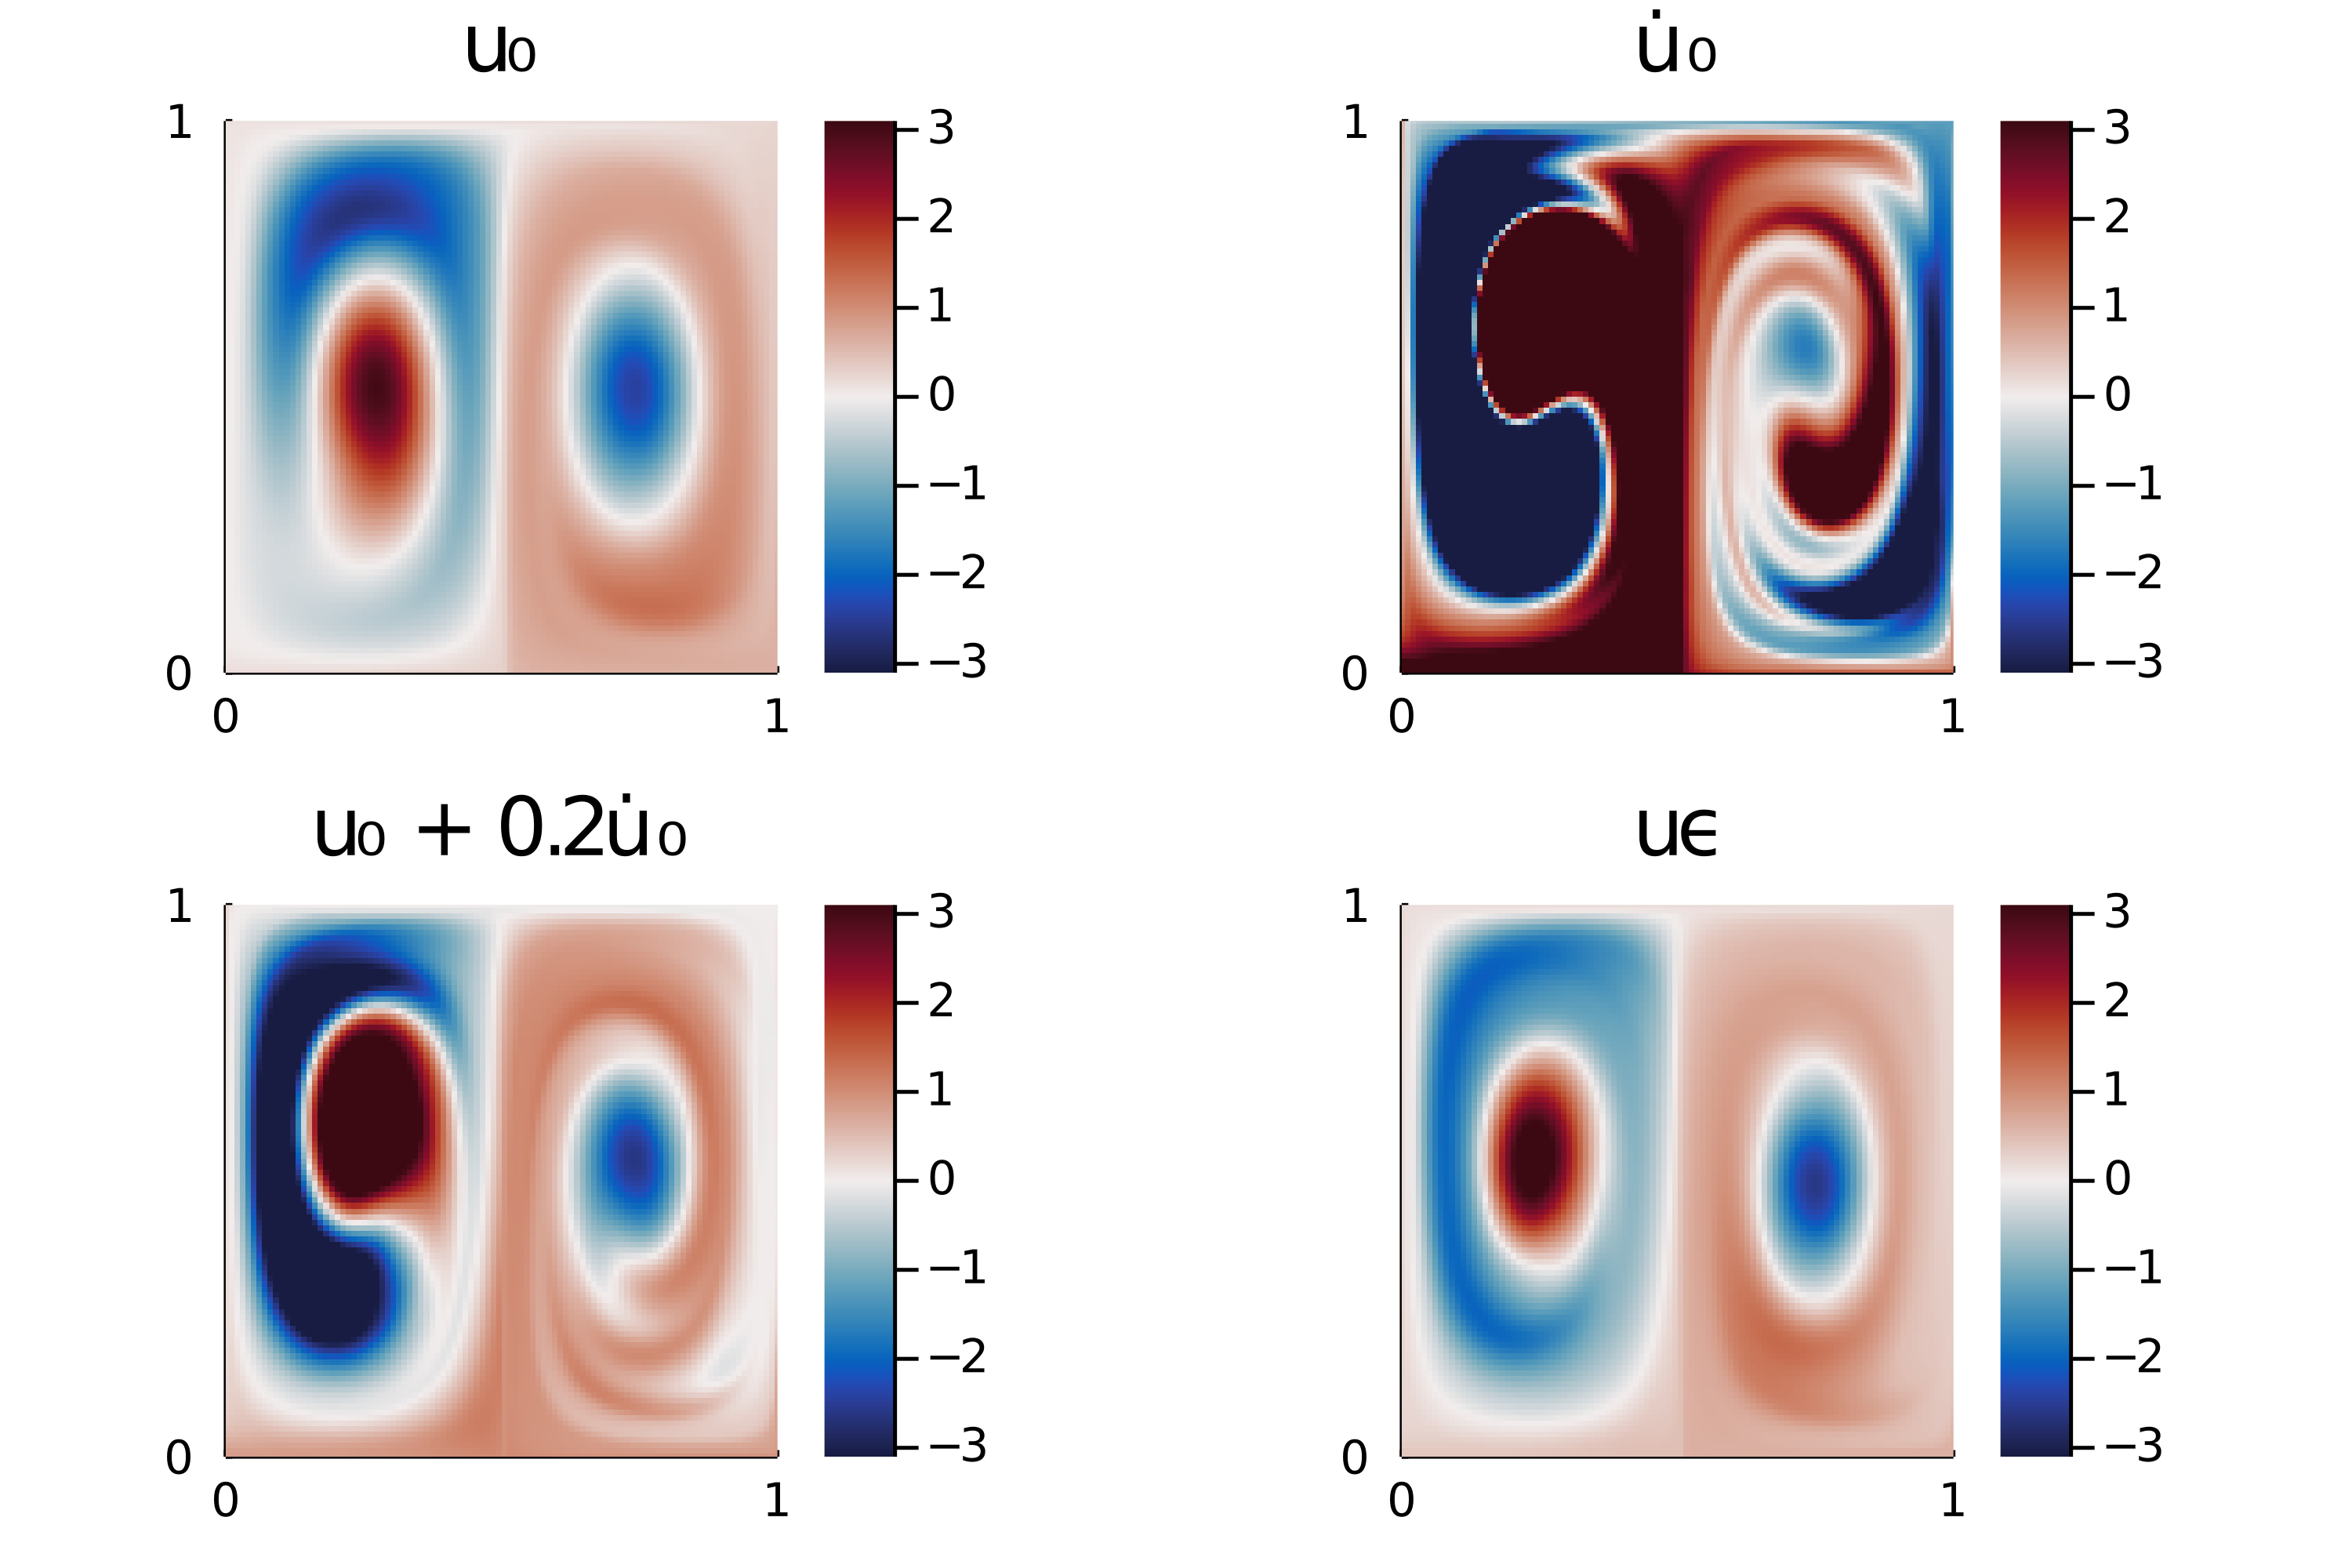

In [13]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmin =     -3.1
cmax =     3.1
cmin_lr =  -3.1
cmax_lr =  3.1
#unfortunately there is no option for colorbar ticks


original      = plot_u(ctx, u₀,         grid_resolution, grid_resolution, title="u₀", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
derivative    = plot_u(ctx, u_dot,       grid_resolution, grid_resolution, title="u̇ ₀",
                colorbar=colorbar, color=color, clims=(cmin_lr,cmax_lr), xticks=xticks, yticks=yticks)
extrapolated  = plot_u(ctx, u₀ + ϵ*u_dot, grid_resolution, grid_resolution, title="u₀ + $(ϵ)u̇ ₀", 
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
exact         = plot_u(ctx, uϵ,          grid_resolution, grid_resolution, title="uϵ",
                colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks)
Plots.plot(original,derivative,extrapolated,exact, fmt=:png, dpi=500)

In [14]:
using Contour

In [15]:
function dynamic_cheeger_value_levelset(levelset)
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: ", level(levelset)
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end
function dynamic_cheeger_value_levelset_nonnegative(levelset)
    if level(levelset) < 0
        return Inf
    end
    curves = lines(levelset)
    if length(curves) != 1 
        @warn "Currently only connected levelsets are allowed! Levelset: $(level(levelset))"
    end
    curve = curves[1]
    return dynamic_cheeger_value(ctx,curve,x -> T(x,0),tolerance=1e-10)
end

dynamic_cheeger_value_levelset_nonnegative (generic function with 1 method)

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -2.437938706735695)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -2.4321878643941575)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -2.4264370220526197)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -2.420686179711082)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -2.4149353373695446)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -2.409184495028007)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -2.4034336526864695)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -2.3976828103449317)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -2.391931968003394)
└ @ M

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.9261137383388487)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.9203628959973111)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.9146120536557736)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.908861211314236)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.9031103689726983)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.8973595266311607)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.8916086842896231)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.8858578419480856)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.880106999606548)
└ @

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.437292139308153)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.4315412969666153)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.4257904546250777)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.4200396122835401)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.4142887699420026)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.408537927600465)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.4027870852589275)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.3970362429173897)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -1.3912854005758521)
└ @

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.9542213826189948)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.9484705402774573)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.9427196979359196)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.936968855594382)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.9312180132528444)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.9254671709113068)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.9197163285697693)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.9139654862282316)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.908214643886694)
└ @

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.494153995295987)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.4884031529544494)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.4826523106129118)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.47690146827137425)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.47115062592983664)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.46539978358829903)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.4596489412467614)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.45389809890522387)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.4481472565636862

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", -0.0053323962652912695)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0004184460762463277)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.006169288417783925)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.011920130759321522)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.01767097310085912)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.023421815442396715)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.029172657783934314)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.034923500125471914)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.0406743424

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4547349910577165)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4604858333992541)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4662366757407917)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4719875180823293)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4777383604238669)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.48348920276540447)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4892400451069421)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.4949908874484797)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.5007417297900173)
└ @ Main 

┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8802973243314987)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8860481666730363)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8917990090145739)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.8975498513561114)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.9033006936976491)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.9090515360391866)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.9148023783807243)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.9205532207222619)
└ @ Main In[15]:4
┌ Warning: ("Currently only connected levelsets are allowed! Levelset: ", 0.9263040630637994)
└ @ Main I

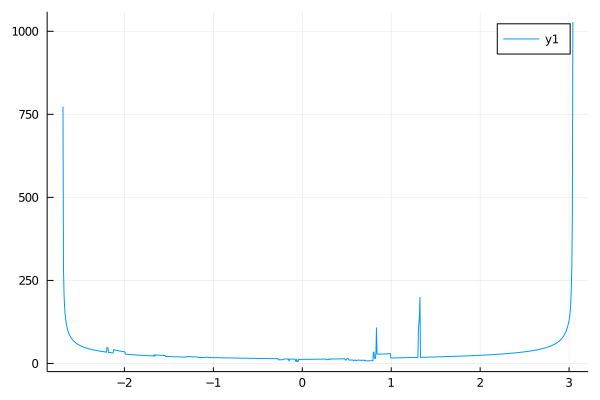

In [16]:
max = maximum(u₀)
min = minimum(u₀)
values = []
for c in range(min,stop=max,length=1000)
    levelset = Main.CoherentStructures.get_levelset(ctx,u₀,c)
    if (length(lines(levelset))>0)
        push!(values,dynamic_cheeger_value_levelset(levelset))
    else 
        push!(values,0)
    end
end
Plots.plot(range(min,stop=max,length=1000)[1:end-1],values[1:end-1])

In [17]:
best_levelset, best_value = get_minimal_levelset(
    ctx,u₀,dynamic_cheeger_value_levelset_nonnegative,n_candidates=1000)
print("Dynamic Cheeger value:\t",best_value,"\n")
print("Levelset:\t\t",level(best_levelset),"\n")

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0007688970081480839
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.006508249155196655
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.01224760130224567
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.017986953449294685
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.0237263055963437
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.029465657743392715
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.03520500989044173
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.040944362037490745
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.04668371418453976
└ @ Main In[15]:15
┌ Warning: Currently on

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.4426990123309218
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.4484383644779708
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.4541777166250198
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.45991706877206884
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.46565642091911785
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.47139577306616687
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.4771351252132159
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.4828744773602649
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.4886138295073139
└ @ Main In[15]:15
┌ Warning: Currently only connecte

┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.8903684798007445
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.8961078319477935
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.9018471840948425
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.9075865362418916
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.9133258883889406
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.9190652405359896
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.9248045926830386
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.9305439448300876
└ @ Main In[15]:15
┌ Warning: Currently only connected levelsets are allowed! Levelset: 0.9362832969771366
└ @ Main In[15]:15
┌ Warning: Currently only connected l

Dynamic Cheeger value:	7.837406381160301
Levelset:		0.700969858948127


cheeger value		length			length transported	volume
28.159582586475985	2.063505046705133	2.192555289860102	0.07557037330889388
7.837406381160301	2.311379915835494	3.0914661931877285	0.3446832948467928


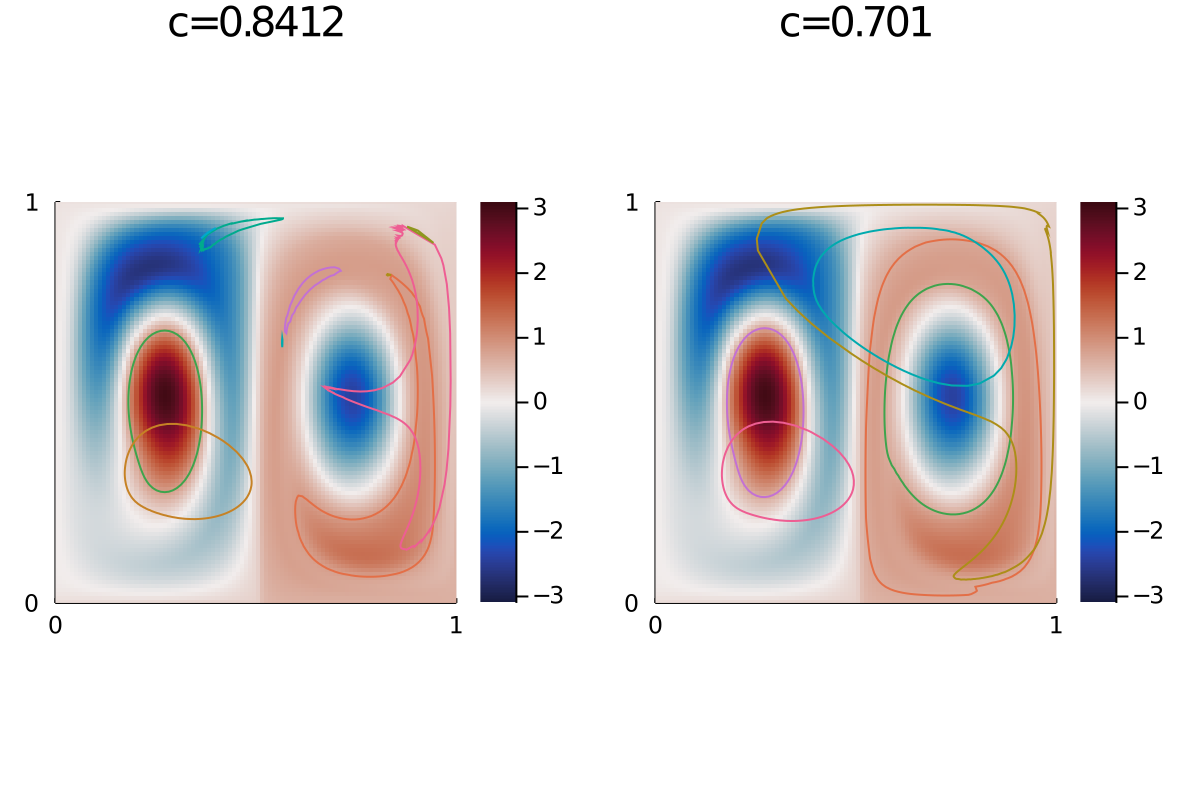

In [18]:
# value from paper
c_paper = 0.8412
plot_paper = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_paper,digits=4))",
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_paper))
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], x->T(x,0))
print("cheeger value\t\tlength\t\t\tlength transported\tvolume\n")
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end

# our value
c_ours = level(best_levelset)
plot_ours = plot_u(ctx, u₀,  grid_resolution, grid_resolution, title="c=$(round(c_ours,digits=4))",
        colorbar=colorbar, color=color, clims=(cmin,cmax), xticks=xticks, yticks=yticks,legend=false)

curves = lines(get_levelset(ctx, u₀, c_ours))
curves = [Main.CoherentStructures.closeCurve(ctx,c) for c in curves]
curves_moved = [Main.CoherentStructures.apply2curve(x->T(x,0),c) for c in curves]

cheeger_value = dynamic_cheeger_value(ctx, curves[1], x->T(x,0))
print("$(cheeger_value)\t$(Main.CoherentStructures.getLength(curves[1]))\t",
    "$(Main.CoherentStructures.getLength(curves_moved[1]))\t$(Main.CoherentStructures.getEuclideanArea(ctx,curves[1]))\n")

for c in curves
    Plots.plot!(coordinates(c))
end
for c in curves_moved
    Plots.plot!(coordinates(c))
end
Plots.plot(plot_paper,plot_ours,fmt=:png,dpi=200,legend=false,aspectratio=1,xlims=(0,1),ylims=(0,1))

In [19]:
using PyCall
using PyPlot
@pyimport matplotlib.pyplot as plt

ErrorException: [91m@pyimport: plt already defined[39m

In [20]:
function plot_vectorfield(xs,ys,dx,dy,ax;scale=1,step=1)
    xs, ys = xs[1:step:end], ys[1:step:end]
    dx, dy = dx[1:step:end,1:step:end], dy[1:step:end,1:step:end]
    ax.quiver(xs,ys,dx',dy',scale=scale,color="blue")
end

plot_vectorfield (generic function with 1 method)

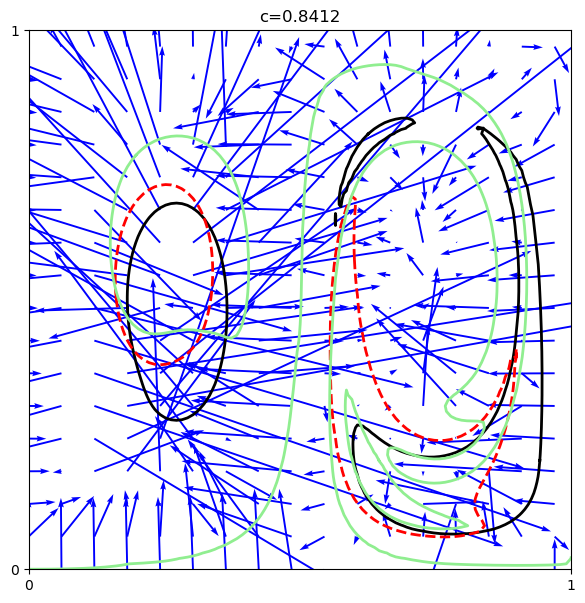

In [21]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot)...,ax,scale=25,step=6)
curves           = lines(get_levelset(ctx, u₀, c_paper))
curves_epsilon   = lines(get_levelset(ctx, uϵ, c_paper))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_paper))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_paper,digits=4))");

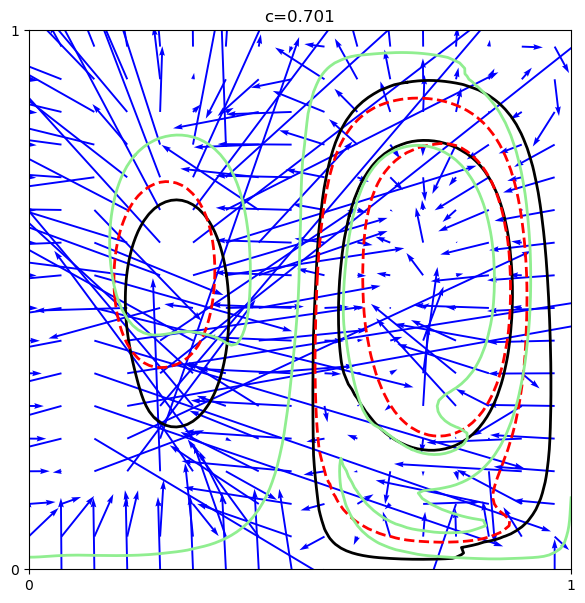

In [22]:
plt.figure(figsize=(7,7), dpi=100)
ax = plt.axes()
ax.set(xlim=(0, 1), ylim=(0, 1), xticks=(0,1), yticks=(0,1))
plot_vectorfield(get_levelset_evolution(ctx,u₀,u_dot)...,ax,scale=25,step=6)
curves           = lines(get_levelset(ctx, u₀, c_ours))
curves_epsilon   = lines(get_levelset(ctx, uϵ, c_ours))
curves_predicted = lines(get_levelset(ctx, u₀ + ϵ*u_dot, c_ours))

for c in curves
    ax.plot(coordinates(c)...,color=:black,linewidth=2)
end
for c in curves_epsilon
    ax.plot(coordinates(c)...,color=:red,linestyle="--",linewidth=2)
end
for c in curves_predicted
    ax.plot(coordinates(c)...,color=:lightgreen,linewidth=2)
end
ax.set_title("c=$(round(c_ours,digits=4))");